In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [3]:
#Using the period 1990-2020 for training and 2021-2023 for testing
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2020-01-01')]
cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2020-01-01')]
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]

indu_test = indu[(indu['Time'] >= '2020-01-01') & (indu['Time'] < '2024-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01') & (cons['Time'] < '2024-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01') & (gdp['Time'] < '2024-01-01')]

#Printing the length of the training and testing data
print("indu lenght: ", len(indu_train), " cons lenght: ", len(cons_train)," gdp lenght: ", len(gdp_train))
print("indu lenght: ", len(indu_test), " cons lenght: ", len(cons_test)," gdp lenght: ", len(gdp_test))

indu lenght:  120  cons lenght:  120  gdp lenght:  120
indu lenght:  16  cons lenght:  16  gdp lenght:  16


In [4]:
# Resetting the index
gdp_train.reset_index(drop=True, inplace=True)
indu_train.reset_index(drop=True, inplace=True)
cons_train.reset_index(drop=True, inplace=True)

# Combine the explanatory variables into a single DataFrame
exog_train = pd.concat([indu_train, cons_train], axis=1)
exog_test = pd.concat([indu_test, cons_test], axis=1)

# Remove the Time column
exog_train.drop('Time', axis=1, inplace=True)

# Initialize an empty list to store forecast values
forecast_values = []

i = 0
while i < len(indu_test):  # Continue looping until all observations are used
    print(f"Iteration {i}:")
    # Fit auto_arima function to the data
    arimax_model = auto_arima(gdp_train['Value'], exogenous=exog_train,
                              start_p=1, start_q=1,
                              max_p=3, max_q=3,
                              m = 4, seasonal=True,
                              trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)

    # Forecast the next value
    forecast = arimax_model.predict(n_periods=1, exogenous=exog_test.iloc[[i]])

    print("Forecast:", forecast)

    # Append the forecasted value to the list
    forecast_values.append(forecast.iloc[0])

    # Assign the last observation from the test set to the training set
    gdp_train.loc[len(gdp_train)] = gdp_test.iloc[i]
    indu_train.loc[len(indu_train)] = indu_test.iloc[i]
    cons_train.loc[len(cons_train)] = cons_test.iloc[i]

    i += 1  # Increment the counter

Iteration 0:
Forecast: 120    571.682444
dtype: float64
Iteration 1:
Forecast: 121    597.07062
dtype: float64
Iteration 2:
Forecast: 122    552.570754
dtype: float64
Iteration 3:
Forecast: 123    604.657951
dtype: float64
Iteration 4:
Forecast: 124    585.489621
dtype: float64
Iteration 5:
Forecast: 125    592.731866
dtype: float64
Iteration 6:
Forecast: 126    618.308945
dtype: float64
Iteration 7:
Forecast: 127    657.289858
dtype: float64
Iteration 8:
Forecast: 128    662.066068
dtype: float64
Iteration 9:
Forecast: 129    687.146769
dtype: float64
Iteration 10:
Forecast: 130    709.873436
dtype: float64
Iteration 11:
Forecast: 131    760.103345
dtype: float64
Iteration 12:
Forecast: 132    717.578938
dtype: float64
Iteration 13:
Forecast: 133    727.646571
dtype: float64
Iteration 14:
Forecast: 134    696.597975
dtype: float64
Iteration 15:
Forecast: 135    697.779873
dtype: float64


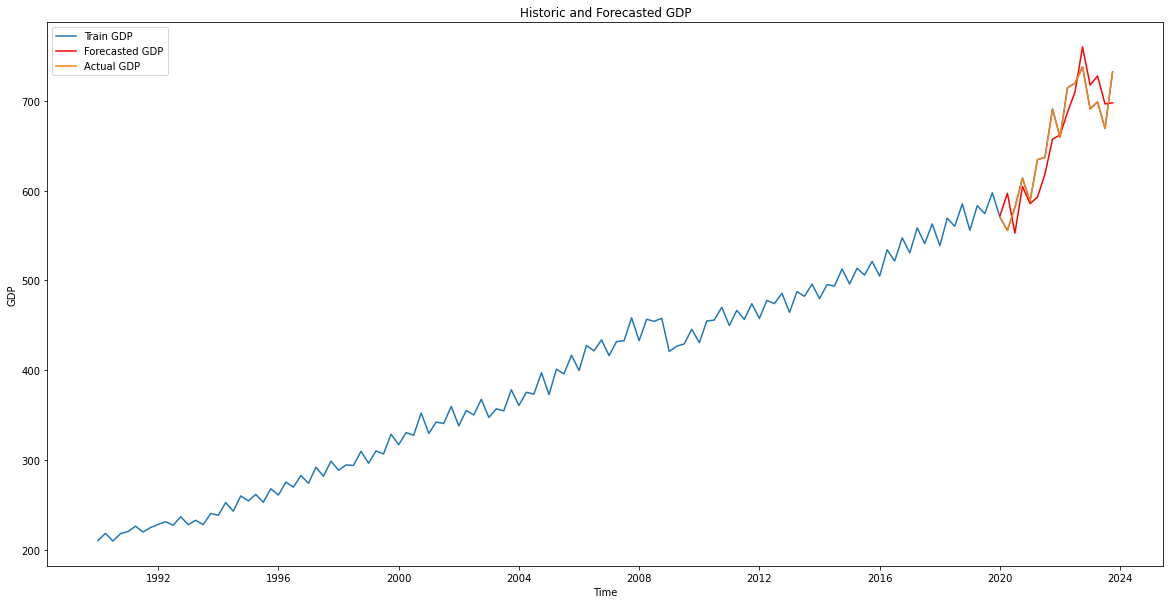

In [5]:
# Plotting historic GDP and forecasted GDP
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), forecast_values, color='red', label='Forecasted GDP')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')

# Set the title and labels
plt.title('Historic and Forecasted GDP')
plt.xlabel('Time')
plt.ylabel('GDP')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [6]:
#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(gdp_test['Value'], forecast_values)
#Calculate the MAPE
mape_value = mean_absolute_percentage_error(gdp_test['Value'], forecast_values) * 100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

#The RMSE is 26. The forecasted values are close to the actual values.
#The MAPE is 3,4%.

The RMSE is 25.850795469356882
The MAPE is 3.3956642245185193


In [7]:
import os
import json

#Define the evaluation metric name for this model
metric_name = "One_Single_Post_SARIMAX"

# Create a dictionary with the MAPE value

# Get the current directory
current_dir = os.getcwd()

# Navigate to the directory where mape_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'mape_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the MAPE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the MAPE value to the dictionary with a corresponding key
data[metric_name] = mape_value

# Write the MAPE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)

# Create a dictionary with the RMSE value

# Navigate to the directory where rsme_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'rsme_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the RMSE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the RMSE value to the dictionary with a corresponding key
data[metric_name] = rmse_value

# Write the RMSE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)